In [ ]:
!pip install --verbose git+https://github.com/mrzv/dionysus.git

In [2]:
!pip install gudhi

In [3]:
import dionysus as dio
import gudhi
import numpy as np
import scipy.spatial as spatial
import cv2

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D

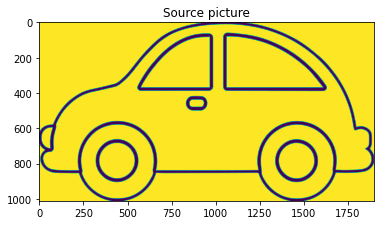

In [5]:
image = cv2.imread("./car.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.title("Source picture")
plt.imshow(image)
plt.show()

**Countours extraction**

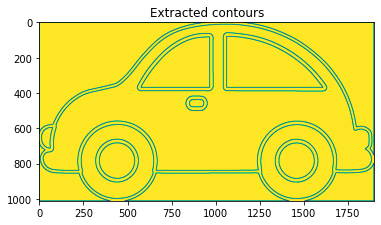

In [6]:
blur = cv2.GaussianBlur(image, (5, 5), 0)
retval, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_with_cont = cv2.drawContours(np.ones(image.shape), contours, -1, (0, 0, 255), 2, cv2.LINE_AA)

plt.title("Extracted contours")
plt.imshow(img_with_cont)
plt.show()

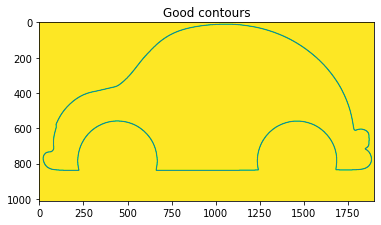

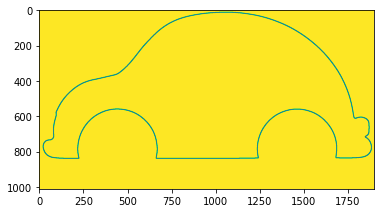

In [7]:
def is_contour_bad(cnt, img):
  if cv2.contourArea(cnt) < img.shape[0] * img.shape[1] * 0.15:
    return True
  if cv2.contourArea(cnt) > img.shape[0] * img.shape[1] * 0.5:
    return True

good_contours = []
for cnt in contours:
  if not is_contour_bad(cnt, image):
    good_contours.append(cnt)
  
img_with_cont = cv2.drawContours(np.ones(image.shape), good_contours, -1, (0, 0, 255), 2, cv2.LINE_AA)

plt.title("Good contours")
plt.imshow(img_with_cont)
plt.show()

for i in range(len(good_contours)):
  plt.imshow(cv2.drawContours(np.ones(image.shape), good_contours, -i, (0, 0, 255), 2, cv2.LINE_AA))
  plt.show()

In [8]:
def plot_with_points(img, points, title="Picture with points"):
  img = img.copy()

  blue = [0, 0, 255]

  for x, y in points:
    img = cv2.circle(img, (y, x), 5, blue, -1)

  plt.title(title)
  plt.imshow(img)
  plt.show()

First 5 points:  [(500, 514), (80, 1054), (11, 40), (450, 60), (800, 986)]


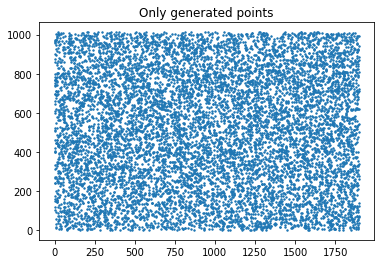

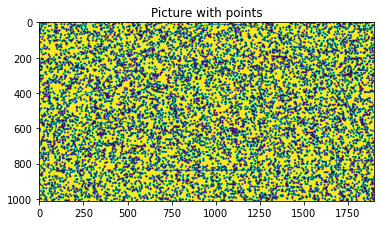

In [9]:
num_points = 10000
radius = 15

x = np.random.randint(0, img_with_cont.shape[0], num_points)
y = np.random.randint(0, img_with_cont.shape[1], num_points)
points = list(zip(x, y))

#print(img_with_cont.shape)
#print(x)
#print(y)
print("First 5 points: ", points[:5])
plt.title("Only generated points")
plt.scatter(y, img_with_cont.shape[0] - x, s=2)
plt.show()

plot_with_points(img_with_cont, points)

**Keep points that are only inside a contour**

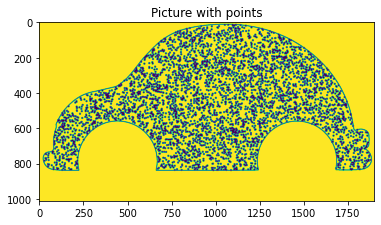

In [10]:
points = list(filter(lambda p: cv2.pointPolygonTest(good_contours[0], (p[1], p[0]), False) == 1, points))

plot_with_points(img_with_cont, points)

**Create circles around points**

In [11]:
def plot_with_circles(img, points, radius, title="Picture with circles"):
  img = img.copy()

  red  = [0, 0, 10]
  blue = [0, 0, 255]

  for x, y in points:
    img = cv2.circle(img, (y, x), 7, blue, -1)
    img = cv2.circle(img, (y, x), radius, red, 2)

  plt.title(title)
  plt.imshow(img)
  plt.show()

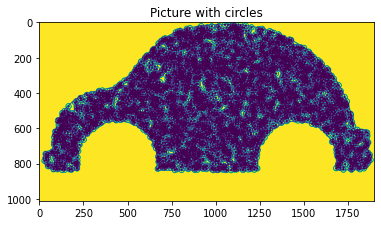

In [12]:
#radius = 50

plot_with_circles(img_with_cont, points, radius)

**Let's find indices of intersection circle centers for every point that we have.**

Neighbors - coordindates of points, whose circles intersect with a given point.

In [13]:
point_tree = spatial.cKDTree(points)

neighbors_indices = []
for x, y in points:
  neighbors_indices.append(point_tree.query_ball_point([x, y], 2 * radius))

neighbors = []
for neigh in neighbors_indices:
  neighbors.append([points[n] for n in neigh])

print("Points: ", points[:10])
print("Neighbor indices: ", neighbors_indices[:10])
print("Neighbor points: ", neighbors[:10])

dict_points = dict()
for idx, coords in enumerate(points):
  dict_points[idx] = { "coords": coords, "neighbors_idx": neighbors_indices[idx], "neighbors_coords": neighbors[idx], "x": coords[0], "y": coords[1] }

Points:  [(500, 514), (80, 1054), (800, 986), (423, 520), (186, 844), (672, 88), (801, 1225), (213, 1417), (386, 898), (172, 1445)]
Neighbor indices:  [[4772, 4114, 310, 4132, 4180, 3861, 4222, 2965, 0, 4685, 4551, 3602, 2688, 3351, 1485, 3722, 1787, 4056, 2563], [4108, 3273, 3266, 809, 4371, 2246, 1604, 2105, 1, 3185, 4559, 152, 4550, 1899], [1655, 3969, 2616, 3363, 4021, 1883, 915, 2, 4485, 3326, 724], [4047, 1012, 4007, 1157, 3578, 1421, 4329, 2986, 1849, 3, 4639, 2296, 1844, 2196, 2155, 3427, 1509], [2570, 1980, 1762, 937, 2053, 3524, 1780, 951, 4, 776], [3784, 12, 896, 3963, 215, 4300, 1155, 1617, 1602, 5, 2747, 1774, 1949], [477, 2970, 384, 2791, 2960, 506, 6, 3897, 1504, 1410, 3726], [2749, 1471, 3662, 1288, 3268, 3685, 1403, 1513, 4296, 1385, 2164, 2093, 1289, 4625, 3622, 7, 2402, 2641, 271, 1475, 3825, 2554], [430, 3084, 4763, 3065, 1979, 682, 3815, 8, 3659, 3580, 4693, 3989, 3391, 2540, 371], [2046, 1800, 2205, 2833, 4614, 1288, 3268, 1394, 1921, 9, 22, 2079, 1017, 1367]]
Nei

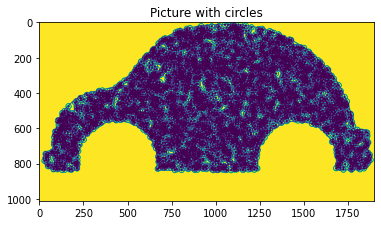

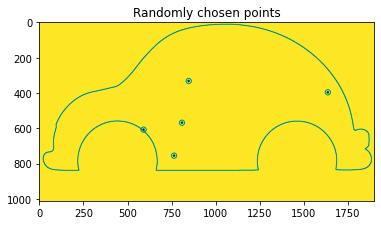

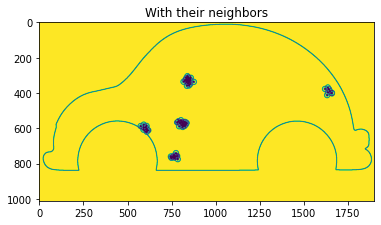

In [14]:
# randomly choose 5 points and check if it has all valid neighbors.

start = np.random.randint(len(points) - 6)
end = start + 5

chosen_randomly = points[start:end]
with_neighbors  = chosen_randomly.copy()

for neighs in neighbors[start:end]:
  with_neighbors += neighs

plot_with_circles(img_with_cont, points, radius)
plot_with_circles(img_with_cont, chosen_randomly, radius, title="Randomly chosen points")
plot_with_circles(img_with_cont, with_neighbors, radius, title="With their neighbors")


**Instead of the straightforward approach above, let's try Gudhi (https://gudhi.inria.fr/python/latest/):**

usetex mode requires TeX.


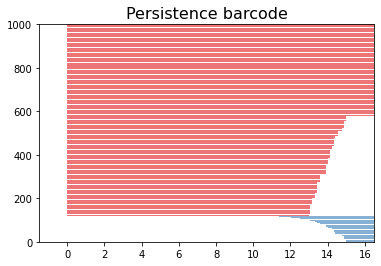

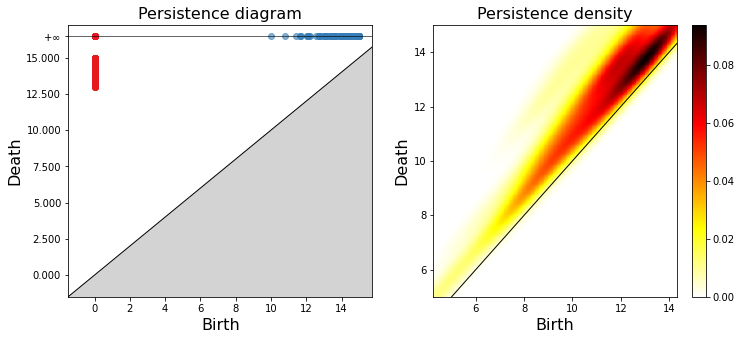

In [15]:
rips_complex = gudhi.RipsComplex(points=points, max_edge_length=radius)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
diag = simplex_tree.persistence(min_persistence=0.4)

# barcode
gudhi.plot_persistence_barcode(diag)
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
gudhi.plot_persistence_diagram(persistence=diag, axes=axes[0])
gudhi.plot_persistence_density(persistence=diag, dimension=1, legend=True, axes=axes[1])
plt.show()